<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Скользящее-среднее-и-среднеквадратичное-отклонение" data-toc-modified-id="Скользящее-среднее-и-среднеквадратичное-отклонение-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Скользящее среднее и среднеквадратичное отклонение</a></span></li><li><span><a href="#Сезонность" data-toc-modified-id="Сезонность-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Сезонность</a></span></li><li><span><a href="#Тренд" data-toc-modified-id="Тренд-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Тренд</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Создание-моделей-и-обучение" data-toc-modified-id="Создание-моделей-и-обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Создание моделей и обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-и-разделение-на-выборки" data-toc-modified-id="Подготовка-и-разделение-на-выборки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка и разделение на выборки</a></span></li><li><span><a href="#Базовая-модель" data-toc-modified-id="Базовая-модель-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Базовая модель</a></span></li><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Установим и нмпортируем необходимые библиотеки

In [1]:
!pip install statsmodels

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

SEED=777

Прочитаем датасет и сохраним в переменную:

In [3]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Выведем первые строки и общую информацию о данных в датасете:

In [4]:
display(data.head())
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Как видно из полученных данных:
- Столбец datetime является индексом таблицы и имеет тип данных Datetime64.
- В столбце num_orders содержится информация о количестве заказов.
- таймфрейм между записями - 10 минут.

Проверим расположены ли данные в хронологическом порядке, поскольку это является важным условием при анализе временных рядов:

In [5]:
if data.index.is_monotonic:
    print('Данные расположены в хронологическом порядке')
else:
    print('Хронология данных нарушена')

Данные расположены в хронологическом порядке


Поскольку нам необходимо сделать предсказания на таймфрейм в 1 час, ресемплируем данные по 1 часу, просуммировав промежуточные данные:

In [6]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Ресемплирование сделали, посмотрим на границы рассматриваемой выборки:

In [7]:
print(f'Временные границы выборки:\n{data.index.min()} - {data.index.max()}')

Временные границы выборки:
2018-03-01 00:00:00 - 2018-08-31 23:00:00


В датасете данные за полгода 2018 года - с начала весны по конец лета.

## Анализ

### Скользящее среднее и среднеквадратичное отклонение

Найдем скользящее среднее и скользящее среднеквадратичное отклонение, задав ширину окна равной 72, и построим графики:

In [8]:
rolling_df = data[['num_orders']].copy()
rolling_df['rolling_mean'] = rolling_df['num_orders'].rolling(72).mean()
rolling_df['rolling_std'] = rolling_df['num_orders'].rolling(72).std()

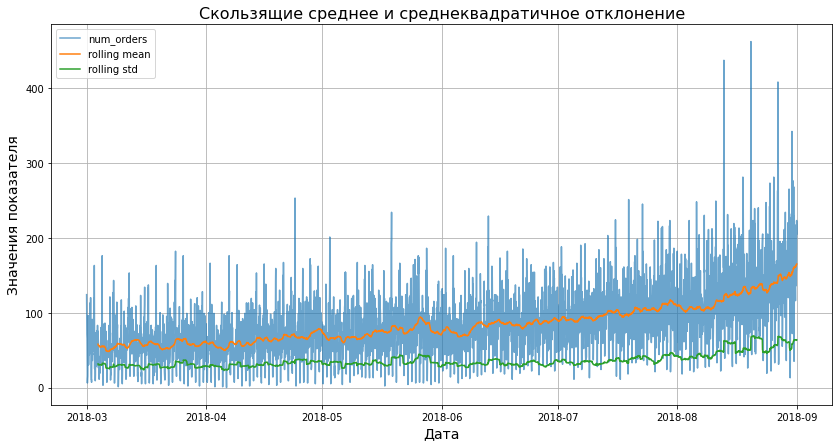

In [9]:
fig = plt.figure(figsize=(14, 7))

ax = fig.add_subplot(1, 1, 1)
ax.grid()
ax.plot(rolling_df['num_orders'], alpha=0.66)
ax.plot(rolling_df[['rolling_mean', 'rolling_std']])
plt.legend(['num_orders', 'rolling mean', 'rolling std'])
plt.title('Скользящие среднее и среднеквадратичное отклонение', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Значения показателя', fontsize=14)
plt.show()

Исходя из полученнйо визуализации, видно, что скользящие среднее и среднеквадратичное отклонение имеют восходящий тренд. То есть временной ряд нестационарный.

Разложим временной ряд на компоненты и поищем в них возможные закономерности.

### Сезонность

С помощью метода seasonal_decompose разложим временной ряд на следующие составляющие: сезонность, тренд и шум. Из данных составляющих нас интересуют только сезонность и тренд.

Проанализируем сезонность для периодов неделя и день:

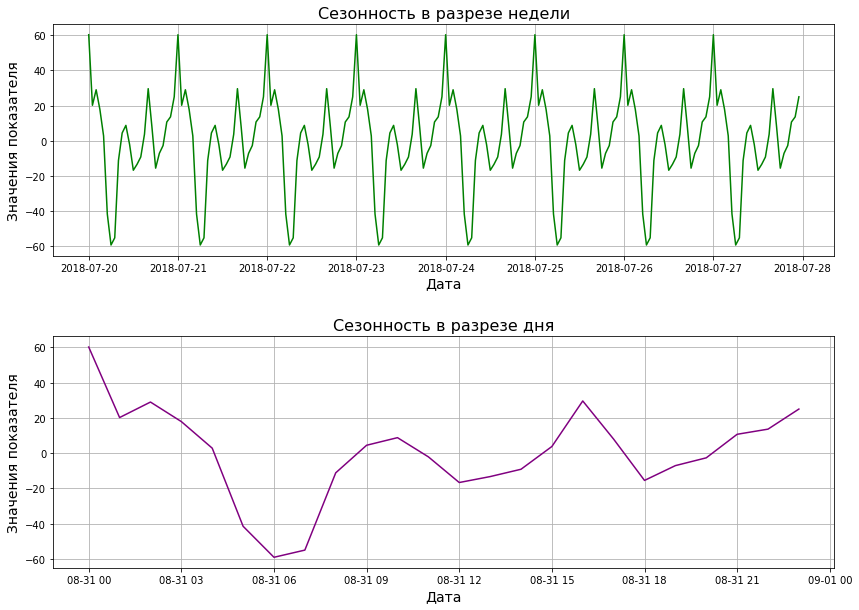

In [10]:
decompose = seasonal_decompose(data[['num_orders']])

fig = plt.figure(figsize=(14, 10))
plt.subplots_adjust(hspace=0.35)
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(decompose.seasonal['2018-07-20':'2018-07-27'], color='green')
ax1.grid()
ax1.set_title('Сезонность в разрезе недели', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Значения показателя', fontsize=14)

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(decompose.seasonal['2018-08-31'], color='purple')
ax2.grid()
ax2.set_title('Сезонность в разрезе дня', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Значения показателя', fontsize=14)
plt.show()

На графиках сезонности для случайной недели и дня можно увидеть следующую закономерность: унижение числа заказов ранним утром (6 часов утра) и пик заказов около полуночи. Вероятно, это связано с тем, что в эти часы не работает общественный транспорт.

### Тренд

Проанализируем тренд:

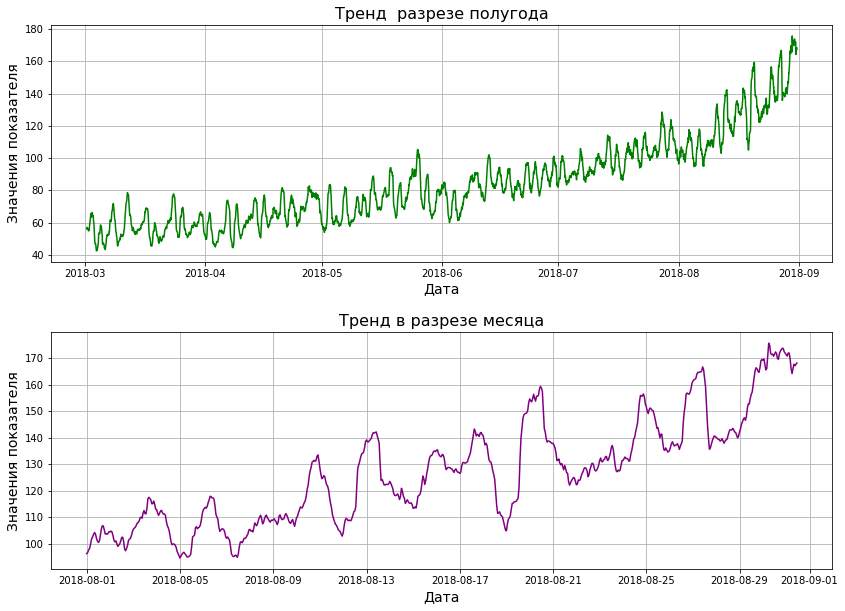

In [11]:
fig = plt.figure(figsize=(14, 10))
plt.subplots_adjust(hspace=0.3)

ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(decompose.trend, color='green')
ax1.grid()
ax1.set_title('Тренд  разрезе полугода', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Значения показателя', fontsize=14)

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(decompose.trend['2018-08'], color='purple')
ax2.grid()
ax2.set_title('Тренд в разрезе месяца', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Значения показателя', fontsize=14)
plt.show()

Как видно из полученных визуализаций, наблюдается тренд на увеличение числа заказов к концу лета.

### Вывод

Датасет представляют собой информацию о количестве заказов за таймфрейм, равный 10 минутам. Рассматриваемый период - с марта по август 2018 года. В рамках этапа предподготовки данные были ресемплированы по 1 часу с суммироваем значений в рамках одного окна.

В ходе анализа данных были замечены следующие закономерности:

- наблюдается тренд на увеличение скользящего среднего и среднеквадратического отклонения, и, соответственно, имеется тренд на увеличение заказов;
- количество заказов менятся в течении дня: наибольшее количество - около 12 часов ночи, наименьшее - около 6 утра.

Для предсказания количества заказов важными будут являться: месяц, день недели и час дня. Необходимо выделить эти параметры как отдельные признаки в обучающей и тестовой выборках.

## Создание моделей и обучение

### Подготовка и разделение на выборки

Подготовим наборы данных, для этого создадим функции:

In [12]:
def features_target_split(df, y_name='num_orders'):
    x = df.drop([y_name], axis=1)
    y = df[y_name]
    return x, y

def make_sets(df, rolling_size, max_lag):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour

    for lag in range(max_lag):
        df[f'lag_{lag+1}'] = df['num_orders'].shift(lag+1)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_size).mean()
    
    df = df.dropna(axis=0)
    x, y = features_target_split(df)
    return x, y

def rmse(model, x, y):
    predictions = model.predict(x)
    return round(mean_squared_error(y, predictions)**0.5, 3) 

Разделим датасет на обучающую, валидационную и тестовую выборки:

In [13]:
train_valid, test = train_test_split(data.copy(), shuffle=False, train_size=0.9)
train, valid = train_test_split(train_valid.copy(), shuffle=False, test_size=test.shape[0])

print('Размеры получившихся выборок:\n '
      'Тренировочная выборка:',train.shape, '\n',
      'Валидационная выборка:', valid.shape, '\n',
      'Тестовая выборка:', test.shape, '\n')

Размеры получившихся выборок:
 Тренировочная выборка: (3532, 1) 
 Валидационная выборка: (442, 1) 
 Тестовая выборка: (442, 1) 



Проверим, что при разделении данных сохранилась последовательность записей:

In [14]:
print('Временной период выборок:\ntrain: {} - {}\nvalid: {} - {}\ntest: {} - {}'
      .format(train.index.min(), train.index.max(),
              valid.index.min(), valid.index.max(),
              test.index.min(), test.index.max()
             ))

Временной период выборок:
train: 2018-03-01 00:00:00 - 2018-07-26 03:00:00
valid: 2018-07-26 04:00:00 - 2018-08-13 13:00:00
test: 2018-08-13 14:00:00 - 2018-08-31 23:00:00


Разделение прошло корректно.

### Базовая модель

Для оценки адекватности модели создадим базовую модель, которая будет предсказывать количество заказов по последнему значению. В качестве метрики качества будет использовать метрику RMSE:

In [15]:
predictions = valid.shift(fill_value=train.iloc[-1, 0])
results = pd.DataFrame([round(mean_squared_error(valid, predictions)**0.5, 3)],
                       columns=['rmse'],
                       index=['Base model'])
results

,rmse
Base model,47.246


### Linear Regression

Рассмотрим модель линейной регрессии. Для этой моделе подберем гиперпараметры для выделения новых признаков из временного ряда, такие как ширина окна для скользящего среднего и число прошлых значений целевого признака:

In [16]:
params = {
    'rolling_size': [24, 48, 72],
    'max_lag': [12, 24, 48]
}
grid_result = pd.DataFrame(columns=['rolling_size', 'max_lag', 'rmse'])

for rolling_size in params['rolling_size']: 
    for max_lag in params['max_lag']:
        
        train_features, train_target = make_sets(train, rolling_size, max_lag)
        valid_features, valid_target = make_sets(valid, rolling_size, max_lag)
        
        model = LinearRegression()
        model.fit(train_features, train_target)
        metric = rmse(model, valid_features, valid_target)
        grid_result.loc[grid_result.shape[0]] = [rolling_size, max_lag, metric]
        
        
display(grid_result)
display(grid_result[grid_result['rmse']==grid_result['rmse'].min()])

,rolling_size,max_lag,rmse
0,24.0,12.0,40.478
1,24.0,24.0,34.469
2,24.0,48.0,31.586
3,48.0,12.0,40.240
4,48.0,24.0,34.375
5,48.0,48.0,31.589
6,72.0,12.0,40.144
7,72.0,24.0,34.059
8,72.0,48.0,31.581


,rolling_size,max_lag,rmse
8,72.0,48.0,31.581


Лучшие результаты удалось получить со значениями ширины окна 24 и числа предыдущих значений 48. Используем эти параметры, обучим модель заново и сохраним результат в таблицу.

In [17]:
train_features, train_target = make_sets(train, 24, 48)
valid_features, valid_target = make_sets(valid, 24, 48)

model = LinearRegression()
model.fit(train_features, train_target)
results.loc['LinearRegression'] = rmse(model, valid_features, valid_target)
results

,rmse
Base model,47.246
LinearRegression,31.586


Результат LinearRegression значительно лучше базовой модели.

### RandomForest

Подберем гиперпараметры глубины деревьев и минимального числа объектов для разделения. Подбор гиперпараметров произведем с помощью функции GridSearchCV, которая использует кросс-валидацию. Для разделения выборки на обучающую и валидационную не подойдет стандартный метод. Для временных рядов используют метод TimeSeriesSplit, который не допускает обучения на данных "из будущего".

In [18]:
%%time
params = {
    'max_depth': [9, 12, 15],
    'min_samples_split': [3, 6, 9]
}
ts_folds = TimeSeriesSplit(n_splits=8)

model = RandomForestRegressor(n_estimators=50, random_state=SEED, criterion='mse')
grid = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=ts_folds, refit=False, n_jobs=-1)
grid.fit(train_features, train_target)

grid_result = pd.DataFrame(grid.cv_results_)[['param_max_depth', 'param_min_samples_split', 'mean_test_score']]
grid_result.columns = ['max_depth', 'min_samples_split', 'mse']
display(grid_result)
display(grid_result[grid_result['mse']==grid_result['mse'].max()])

,max_depth,min_samples_split,mse
0,9,3,-511.547176
1,9,6,-511.482183
2,9,9,-511.708312
3,12,3,-507.490228
4,12,6,-507.199690
5,12,9,-508.378203
6,15,3,-507.142393
7,15,6,-507.445887
8,15,9,-507.112212


,max_depth,min_samples_split,mse
8,15,9,-507.112212


CPU times: user 1min 41s, sys: 163 ms, total: 1min 41s
Wall time: 1min 42s


Лучший результат получили с гиперпараметрами глубины деревьев 15 и числом объектов для разделения 6. Обучим модель заново и получим предсказания на валидационной выборке:

In [19]:
model = RandomForestRegressor(n_estimators=50,
                                 random_state=SEED,
                                 criterion='mse',
                                 max_depth=15, 
                                 min_samples_split=6, 
                                 n_jobs=-1)
model.fit(train_features, train_target)

results.loc['RandomForest'] = rmse(model, valid_features, valid_target)
results

,rmse
Base model,47.246
LinearRegression,31.586
RandomForest,32.574


### LightGBM

Подберем гиперпараметры глубины деревьев и шаг обучения:

In [20]:
%%time
params = {
    'max_depth': [6, 8, 10],
    'learning_rate': [0.1, 0.12, 0.15]
}
ts_folds = TimeSeriesSplit(n_splits=8)

model = LGBMRegressor(n_estimators=100, random_state=SEED)
grid = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=ts_folds, refit=False)
grid.fit(train_features, train_target)

grid_result = pd.DataFrame(grid.cv_results_)[['param_max_depth', 'param_learning_rate', 'mean_test_score']]
grid_result.columns = ['max_depth', 'learning_rate', 'mse']
display(grid_result)
display(grid_result[grid_result['mse']==grid_result['mse'].max()])

,max_depth,learning_rate,mse
0,6,0.1,-498.580632
1,8,0.1,-495.173386
2,10,0.1,-495.987050
3,6,0.12,-495.303660
4,8,0.12,-504.298377
5,10,0.12,-497.229050
6,6,0.15,-509.189664
7,8,0.15,-499.438930
8,10,0.15,-503.182208


,max_depth,learning_rate,mse
1,8,0.1,-495.173386


CPU times: user 1min 15s, sys: 388 ms, total: 1min 15s
Wall time: 1min 16s


Лучшие результаты получили с гиперпараметрами глубины деревьев 8 и шагом обучения 0.1:

In [21]:
model = LGBMRegressor(n_estimators=100, random_state=SEED, max_depth=8, learning_rate=0.1)
model.fit(train_features, train_target)

results.loc['Light GBM'] = rmse(model, valid_features, valid_target)
results

,rmse
Base model,47.246
LinearRegression,31.586
RandomForest,32.574
Light GBM,30.803


### Вывод

В рамках данного этапа были обучены различные модели машинного обучения, среди которых базовая модель, линейная регрессия, случайный лес и градиентный бустинг. Заказчиком заявлен максимальный RMSE, равный 48. Результаты всех моделей оказались лучше порогового значения. Наилучший результат на обучении показала модель LightGBM, эту модель будем использовать для предсказаний на тестовой выборке.

## Тестирование

Составим новую обучающую выборку, совместно с валидационной выборкой:

In [22]:
train_features, train_target = make_sets(train_valid, 24, 48)
test_features, test_target = make_sets(test, 24, 48)

Получим предсказания на тестовой выборке и вычислим среднюю абсолютную ошибку предсказаний:

In [23]:
model = LGBMRegressor(n_estimators=100, random_state=SEED, max_depth=8, learning_rate=0.1)
model.fit(train_features, train_target)

print('RMSE на тестовой выборке: {:.3f}'.format(rmse(model, test_features, test_target)))

RMSE на тестовой выборке: 40.691


Представим на графике результаты предсказаний на тестовой выборке и реальные значения количества заказов и сравним их:

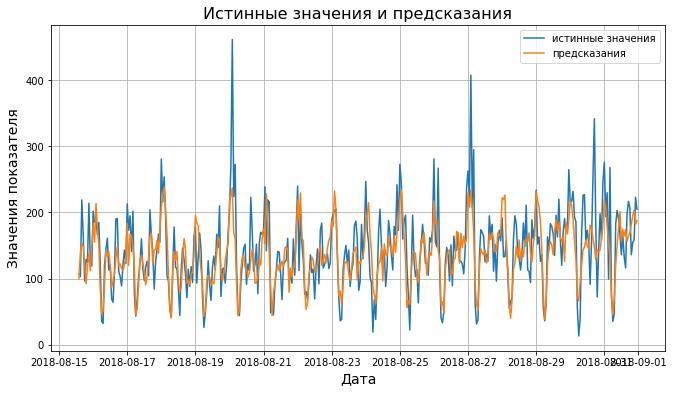

In [24]:
predictions = pd.Series(model.predict(test_features), index=test_target.index)
fig = plt.figure(figsize=(11,6))

ax = fig.add_subplot(1, 1, 1)
ax.grid()
ax.plot(test_target)
ax.plot(predictions)
plt.legend(['истинные значения', 'предсказания'])
plt.title('Истинные значения и предсказания', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Значения показателя', fontsize=14)
plt.show()

На графике видно, что предсказания довольно точно повторяют реальные данные, за исключением участков с очевидными выбросами.

## Вывод

В рамках данной работы был проведен анализ исходных данных и построены новые признаки для обучения моделей. В ходе анализа удалось установить ряд закономерностей:

- наблюдается тренд на увеличение скользящего среднего и среднеквадратического отклонения, и, соответственно, имеется тренд на увеличение заказов в рамках рассматриваемого периода;
- количество заказов менятся в течении дня: наибольшее количество - около 12 часов ночи, наименьшее - около 6 утра.

Эти закономерности указывают на признаки, оказывающие влияние на количество заказов, такие как месяц года, день недели и время суток. Другие построенные признаки: скользящее среднее и значения за предыдущие периоды. Параметры для их определения были определены подбором. В результате были получены наборы данных, готовые к обучению.

Для предсказаний были выбраны модели линейной регрессии, случайного леса, градиентного бустинга. Результаты оценивались метрикой RMSE, и ошибка всех моделей оказалась лучше максимальной заявленной по условию задач. 

Тем не менее лучшей моделью оказалась модель, построенная по алгоритму LIghtGBM. Эту модель использовали для предсказаний на тестовой выборке. Метрика качества RMSE получилась равной 40.691, что, как было отмечено выше, удовлетворяет требованиям задачи.